# Test 2: SOTA LLMs (GPT-5, Gemini 3 Pro, Claude Sonnet 4.5)

Testing if state-of-the-art LLMs have **bias towards resume writing style**.

**Metrics:** Accuracy, Inconsistency Rate, Rank Difference

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("../Test 2 Data/test2_resumes.csv")
styles = ['neutral', 'overstated', 'understated']
model_names = ['gpt5', 'gemini3', 'sonnet45']

# Check if predictions already exist
if os.path.exists("llm_predictions.csv"):
    print("Loading existing predictions...")
    results_df = pd.read_csv("llm_predictions.csv")
    valid_df = results_df[~results_df['prediction'].isin(['error', 'unknown'])].copy()
    print(f"Loaded {len(valid_df)} valid predictions")
else:
    print("Running predictions...")
    import json
    import urllib.request
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import time
    
    OPENROUTER_URL = "https://openrouter.ai/api/v1/chat/completions"
    OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
    if not OPENROUTER_API_KEY:
        raise ValueError("Set OPENROUTER_API_KEY environment variable")
    
    MODELS = {'gpt5': 'openai/gpt-5', 'gemini3': 'google/gemini-3-pro-preview', 'sonnet45': 'anthropic/claude-sonnet-4.5'}
    
    PROMPT = """Classify this resume's seniority level. Respond with ONLY one word: junior, mid, or senior.\n\nResume:\n{resume_text}\n\nSeniority level:"""
    
    def call_api(model_id, text):
        try:
            payload = json.dumps({"model": model_id, "messages": [{"role": "user", "content": PROMPT.format(resume_text=text[:8000])}]}).encode("utf-8")
            req = urllib.request.Request(OPENROUTER_URL, data=payload, headers={"Authorization": f"Bearer {OPENROUTER_API_KEY}", "Content-Type": "application/json"})
            with urllib.request.urlopen(req, timeout=120) as resp:
                response = json.loads(resp.read().decode("utf-8"))["choices"][0]["message"]["content"].strip().lower()
            return "junior" if "junior" in response else "mid" if "mid" in response else "senior" if "senior" in response else "unknown"
        except:
            return "error"
    
    tasks = [{'idx': idx, 'true_seniority': row['seniority'], 'style': style, 'model': m, 'model_id': MODELS[m], 'text': str(row[style])}
             for idx, row in df.iterrows() for style in styles for m in model_names]
    
    results = []
    with ThreadPoolExecutor(max_workers=15) as executor:
        futures = {executor.submit(lambda t: {**t, 'prediction': call_api(t['model_id'], t['text']), 'correct': call_api(t['model_id'], t['text']) == t['true_seniority']}, task): task for task in tasks}
        for i, future in enumerate(as_completed(futures)):
            results.append(future.result())
            if (i+1) % 100 == 0: print(f"Processed {i+1}/{len(tasks)}")
    
    results_df = pd.DataFrame(results)
    results_df.to_csv("llm_predictions.csv", index=False)
    valid_df = results_df[~results_df['prediction'].isin(['error', 'unknown'])].copy()
    print(f"Saved {len(valid_df)} valid predictions")

# Add rank columns
seniority_rank = {'junior': 0, 'mid': 1, 'senior': 2}
valid_df['true_rank'] = valid_df['true_seniority'].map(seniority_rank)
valid_df['pred_rank'] = valid_df['prediction'].map(seniority_rank)
valid_df['rank_diff'] = valid_df['pred_rank'] - valid_df['true_rank']

Loading existing predictions...
Loaded 1078 valid predictions


---
## Metric 1: Accuracy by Style

In [2]:
print("ACCURACY BY STYLE")
print("=" * 50)
for model_name in model_names:
    print(f"\n{model_name.upper()}")
    model_df = valid_df[valid_df['model'] == model_name]
    for style in styles:
        style_df = model_df[model_df['style'] == style]
        if len(style_df) > 0:
            print(f"  {style:<15}: {style_df['correct'].mean():.1%}")

ACCURACY BY STYLE

GPT5
  neutral        : 71.7%
  overstated     : 59.2%
  understated    : 89.2%

GEMINI3
  neutral        : 79.0%
  overstated     : 78.2%
  understated    : 92.5%

SONNET45
  neutral        : 99.2%
  overstated     : 98.3%
  understated    : 98.3%


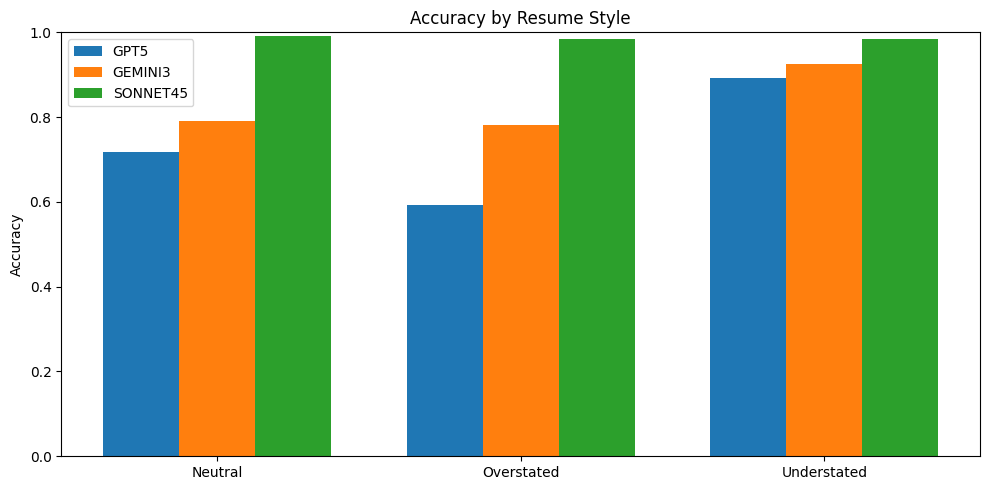

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(styles))
width = 0.25
for i, model_name in enumerate(model_names):
    model_df = valid_df[valid_df['model'] == model_name]
    accs = [model_df[model_df['style'] == s]['correct'].mean() if len(model_df[model_df['style'] == s]) > 0 else 0 for s in styles]
    ax.bar(x + i*width, accs, width, label=model_name.upper())
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy by Resume Style')
ax.set_xticks(x + width)
ax.set_xticklabels(['Neutral', 'Overstated', 'Understated'])
ax.legend()
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

---
## Metric 2: Inconsistency Rate

In [4]:
print("INCONSISTENCY RATE")
print("=" * 50)
inconsistency_rates = {}
for model_name in model_names:
    model_df = valid_df[valid_df['model'] == model_name]
    inconsistent = sum(1 for idx in df.index if len(model_df[model_df['idx'] == idx]) == 3 and len(model_df[model_df['idx'] == idx]['prediction'].unique()) > 1)
    total = model_df['idx'].nunique()
    rate = inconsistent / total * 100 if total > 0 else 0
    inconsistency_rates[model_name] = rate
    print(f"{model_name.upper()}: {inconsistent}/{total} ({rate:.1f}%)")

INCONSISTENCY RATE
GPT5: 39/120 (32.5%)
GEMINI3: 20/120 (16.7%)
SONNET45: 5/120 (4.2%)


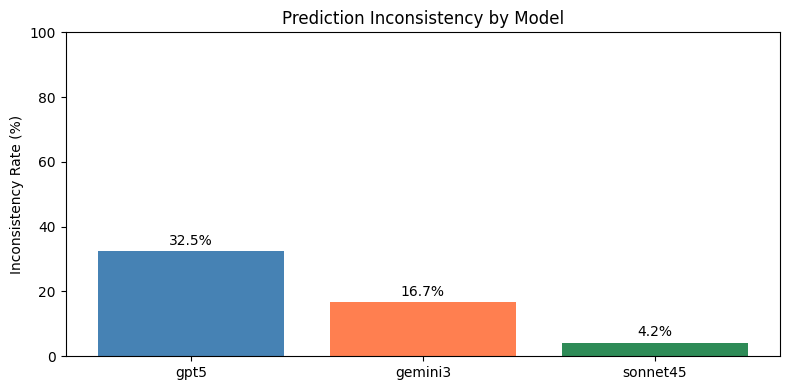

In [5]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(model_names, [inconsistency_rates[m] for m in model_names], color=['steelblue', 'coral', 'seagreen'])
ax.set_ylabel('Inconsistency Rate (%)')
ax.set_title('Prediction Inconsistency by Model')
ax.set_ylim(0, 100)
for i, m in enumerate(model_names):
    ax.text(i, inconsistency_rates[m] + 2, f'{inconsistency_rates[m]:.1f}%', ha='center')
plt.tight_layout()
plt.show()

---
## Metric 3: Rank Difference

In [6]:
print("RANK DIFFERENCE BY STYLE")
print("=" * 50)
for model_name in model_names:
    print(f"\n{model_name.upper()}")
    model_df = valid_df[valid_df['model'] == model_name]
    for style in styles:
        style_df = model_df[model_df['style'] == style]
        if len(style_df) > 0:
            print(f"  {style:<15}: {style_df['rank_diff'].mean():+.3f}")

RANK DIFFERENCE BY STYLE

GPT5
  neutral        : +0.283
  overstated     : +0.408
  understated    : +0.108

GEMINI3
  neutral        : +0.210
  overstated     : +0.218
  understated    : +0.075

SONNET45
  neutral        : +0.008
  overstated     : +0.000
  understated    : -0.017


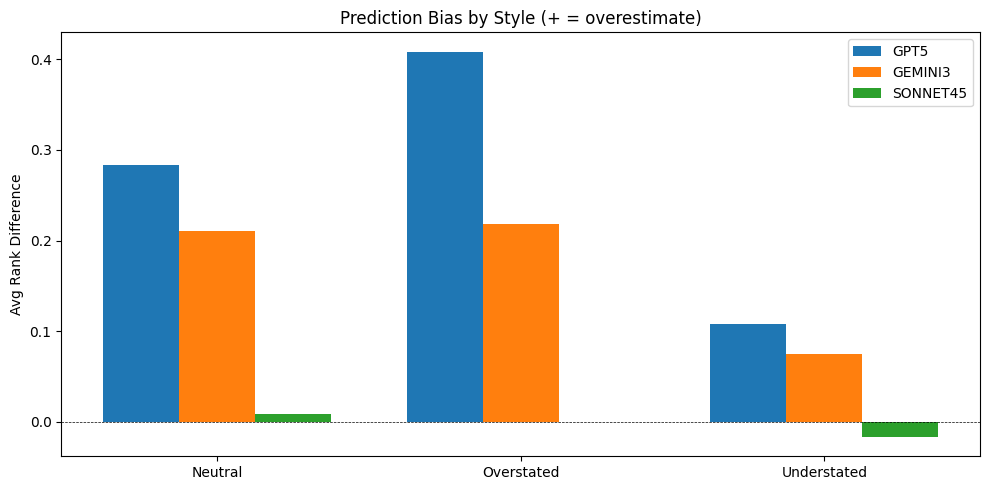

In [7]:
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(styles))
width = 0.25
for i, model_name in enumerate(model_names):
    model_df = valid_df[valid_df['model'] == model_name]
    diffs = [model_df[model_df['style'] == s]['rank_diff'].mean() if len(model_df[model_df['style'] == s]) > 0 else 0 for s in styles]
    ax.bar(x + i*width, diffs, width, label=model_name.upper())
ax.set_ylabel('Avg Rank Difference')
ax.set_title('Prediction Bias by Style (+ = overestimate)')
ax.set_xticks(x + width)
ax.set_xticklabels(['Neutral', 'Overstated', 'Understated'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()